# Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import functools
import spatialdata
import spatialdata_plot
import spatialdata_io as sdio
import numpy as np
import pandas as pd
import corescpy as cr

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Find File Name

In [2]:
# File Paths
libid = "50006B"
ddd = "/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
dir_data = "/mnt/cho_lab/bbdata2/outputs/TUQ97N"  # data directory
out_dir = os.path.join(ddd, "outputs/TUQ97N/nebraska")  # output directory
file_mdf = os.path.join(ddd, "samples.csv")  # metadata
files = functools.reduce(lambda i, j: i + j, [[os.path.join(
    run, i) for i in os.listdir(os.path.join(
        dir_data, run))] for run in os.listdir(dir_data)])  # all data paths

# Metadata
col_inflamed, col_stricture, cso, col_sample, col_subject, col_condition = (
    "Inflamed", "Stricture", "Sample ID", "Sample", "Patient", "Condition")
key_uninfl, key_infl, key_stric = "Uninflamed", "Inflamed", "Stricture"
m_d = (pd.read_excel if file_mdf[-4:] == "xlsx" else pd.read_csv)(
    file_mdf, dtype={"Slide ID": str}).rename({
        "Name": col_subject, "Inflammation": col_inflamed}, axis=1)
m_d.loc[:, col_condition] = m_d.apply(lambda x: "Stricture" if x[
    col_stricture].lower() in ["stricture", "yes"] else x[
        col_inflamed].capitalize(), axis=1)  # inflamation/stricture condition
m_d.loc[:, col_sample] = m_d[[col_condition, cso]].apply("-".join, axis=1)

# Find File Path & Condition-ID String
file_path = np.array(files)[np.where([libid == os.path.basename(
    x).split("__")[2].split("-")[0] for x in files])[0][0]]
lib = m_d.reset_index().set_index(cso).loc[libid][col_sample]

## Load Data

In [3]:
self = cr.Spatial(os.path.join(dir_data, file_path), library_id=lib)
if os.path.exists(os.path.join(out_dir, f"{lib}.h5ad")):  # processed object?
    self.update_from_h5ad(os.path.join(out_dir, f"{lib}.h5ad"))
self.get_layer("counts", inplace=True)  # start with integer counts data
self.adata



<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-007/output-XETG00189__0022407__50006B-TUQ97N-EA__20240411__205514/
         cell_feature_matrix.h5                                                                                    




Counts: Initial


	Observations: 116837

	Genes: 469







 AnnData object with n_obs × n_vars = 116837 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'
    layers: 'counts' 

                      gene_ids    feature_types   genome
gene_symbols                                           
ABCA7         ENSG00000064687  Gene Expression  Unknown
ACTA2         ENSG00000107796  Gene Expression  Unknown
ACTG2         ENSG00000163017  Gene Expression  Unknown
ADAM15        ENSG00000143537  Gene Expression  Unknown
ADAM28        ENSG00000042980  Gene Expression  Unknown 

 



col_gene_symbols="gene_symbols"
col_cell_type="leiden"
col_sample_id="Sample"
col_b

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 34128, 51148), (5, 17064, 25574), (5, 8532, 12787), (5, 4266, 6393), (5, 2133, 3196)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (34128, 51148), (17064, 25574), (8532, 12787), (4266, 6393), (2133, 3196)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (34128, 51148), (17064, 25574), (8532, 12787), (4266, 6393), (2133, 3196)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (116837, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (116837, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (114734, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (78976, 469)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), ce

# Plot

In [ ]:
# sdata.pl.render_shapes("cell_boundaries").pl.show()  # not working?
sdata.pl.render_labels("cell_labels").pl.show()
# sdata.pl.render_images("morphology_focus").pl.show()  # takes long

# See Transcripts Data

In [ ]:
points = self.adata.points["transcripts"].compute()
points

# Crop Data by Xenium Explorer Selection

## Xenium Explorer Selection File

In [15]:
# coord_suffix = "mucosa"
coord_suffix = "mucosa_CSF2"
dir_coord = os.path.join(out_dir, "coordinates", coord_suffix)  # coordinates

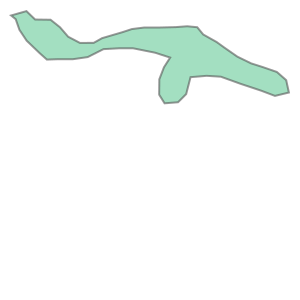

In [18]:
coords = sdio.xenium_explorer_selection(
    os.path.join(dir_coord, s + f"_{coord_suffix}_2.csv"))
coords

In [26]:
type(coords)

shapely.geometry.multipolygon.MultiPolygon

## Crop

In [ ]:
sdata = self.crop(os.path.join(dir_coord, libid + f"_{coord_suffix}.csv"))

# Workspace

In [3]:
elements = getattr(self.adata, "shapes")

In [ ]:
coords = sdio.xenium_explorer_selection(os.path.join(
    dir_coord, libid + f"_{coord_suffix}.csv"))
sdata_cropped = spatialdata.polygon_query(self.adata, coords, **{
                "target_coordinate_system": "global",
                "filter_table": True})

In [23]:
sdata

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 72335, 48440), (5, 36167, 24220), (5, 18084, 12110), (5, 9042, 6055), (5, 4520, 3027)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (72335, 48440), (36167, 24220), (18084, 12110), (9042, 6055), (4520, 3027)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (72335, 48440), (36167, 24220), (18084, 12110), (9042, 6055), (4520, 3027)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (277685, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (269452, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (269480, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (263895, 469)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes)

In [16]:
sdata

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 17854, 11974), (5, 8927, 5987), (5, 4464, 2993), (5, 2232, 1497), (5, 1116, 748)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (17854, 11974), (8927, 5987), (4464, 2993), (2232, 1497), (1116, 748)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (17854, 11974), (8927, 5987), (4464, 2993), (2232, 1497), (1116, 748)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (25457, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (24621, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (24621, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (21535, 469)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes), cell_circles (Sha

In [31]:
# import shapely

# s = "50336B"

# coords = [sdio.xenium_explorer_selection(os.path.join(
#     dir_coord, s + f"_{coord_suffix}{i}.csv")) for i in ["_1", "_2"]]
# coords = shapely.MultiPolygon(coords)
# print(f"\n\n{'*' * 40}\n{s}\n{'*' * 40}\n\n")
# file_path = np.array(files)[np.where([s == os.path.basename(
#     x).split("__")[2].split("-")[0] for x in files])[0][0]]
# lib = m_d.reset_index().set_index(cso).loc[s][col_sample]
# self = cr.Spatial(os.path.join(dir_data, file_path), library_id=lib)
# self.update_from_h5ad(os.path.join(out_dir, f"{lib}.h5ad"))
sdata = self.crop(coords)
sdata.pl.render_labels("cell_labels").pl.show()
self.adata = sdata
self.write(os.path.join(out_dir, f"{lib}_{coord_suffix}.h5ad"))

In [ ]:
# for s in ["50336C", "50403B", "50006A", "50217B", "50217A",
#           "50336B", "50403A2", "50006B"]:
for s in ["50336C", "50403B", "50006A", "50217B", "50217A",
          "50403A2", "50006B"]:
    print(f"\n\n{'*' * 40}\n{s}\n{'*' * 40}\n\n")
    file_path = np.array(files)[np.where([s == os.path.basename(
        x).split("__")[2].split("-")[0] for x in files])[0][0]]
    lib = m_d.reset_index().set_index(cso).loc[s][col_sample]
    self = cr.Spatial(os.path.join(dir_data, file_path), library_id=lib)
    self.update_from_h5ad(os.path.join(out_dir, f"{lib}.h5ad"))
    sdata = self.crop(os.path.join(dir_coord, s + f"_{coord_suffix}.csv"))
    sdata.pl.render_labels("cell_labels").pl.show()
    self.adata = sdata
    self.write(os.path.join(out_dir, f"{lib}_{coord_suffix}.h5ad"))



****************************************
50336C
****************************************




<<< INITIALIZING SPATIAL CLASS OBJECT >>>

INFO     reading                                                                                                   
         /mnt/cho_lab/bbdata2/outputs/TUQ97N/CHO-010/output-XETG00189__0011047__50336C-TUQ97N-EA__20240422__175051/
         cell_feature_matrix.h5                                                                                    


KeyboardInterrupt: 

In [71]:
self.adata

SpatialData object with:
├── Images
│     └── 'morphology_focus': MultiscaleSpatialImage[cyx] (5, 74826, 48440), (5, 37413, 24220), (5, 18706, 12110), (5, 9353, 6055), (5, 4676, 3027)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (74826, 48440), (37413, 24220), (18706, 12110), (9353, 6055), (4676, 3027)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (74826, 48440), (37413, 24220), (18706, 12110), (9353, 6055), (4676, 3027)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (387961, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (387961, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (379551, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (387961, 469)
with coordinate systems:
▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labels), transcripts (Points), cell_boundaries (Shapes)

In [ ]:
self.plot_spatial()

In [ ]:
# To Reload Past Cropping

# for s in ["50336B", "50336C", "50403B", "50006A", "50217B", "50217A",
#           "50403A2", "50006B"]:
#     print(f"\n\n{'*' * 40}\n{s}\n{'*' * 40}\n\n")
#     file_path = np.array(files)[np.where([s == os.path.basename(
#         x).split("__")[2].split("-")[0] for x in files])[0][0]]
#     lib = m_d.reset_index().set_index(cso).loc[s][col_sample]
#     self = cr.Spatial(os.path.join(dir_data, file_path), library_id=lib)
#     table = sc.read(os.path.join(out_dir, f"{lib}_{coord_suffix}.h5ad"))
#     sdata = copy.deepcopy(self.adata)
#     sdata = cr.pp.subset_spatial(
#         sdata, col_region=col_sample_id, col_cell_id="cell_id",
#         key_cell_id=table.obs["cell_id"].to_list())
#     sdata.pl.render_labels("cell_labels").pl.show()

In [ ]:
    from spatialdata.transformations import get_transformation, set_transformation
    from spatialdata._core.operations.transform import transform

    polygon_gdf = ShapesModel.parse(GeoDataFrame(geometry=[polygon]))

    m_without_c, input_axes_without_c, output_axes_without_c = _get_axes_of_tranformation(
        element, target_coordinate_system
    )
    spatial_transform = Affine(m_without_c, input_axes=input_axes_without_c, output_axes=output_axes_without_c)

    m_without_c_linear = m_without_c[:-1, :-1]
    case = _get_case_of_bounding_box_query(m_without_c_linear, input_axes_without_c, output_axes_without_c)





    polygon_gdf = _get_polygon_in_intrinsic_coordinates(element, target_coordinate_system, polygon)
    polygon = polygon_gdf["geometry"].iloc[0]

    buffered = circles_to_polygons(element) if ShapesModel.RADIUS_KEY in element.columns else element

    OLD_INDEX = "__old_index"
    if OLD_INDEX in buffered.columns:
        assert np.all(element[OLD_INDEX] == buffered.index)
    else:
        buffered[OLD_INDEX] = buffered.index

    print(buffered.geometry)